# Trying Tensor Flow 2

In [62]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

tf.compat.v1.disable_eager_execution()

print("Using the following TensorFlow version:")
print(tf.__version__)
# Network training parameters
learning_rate    = 0.001
training_epochs  = 5000
min_x = -10
max_x = 10
Ngen  = 10000

# Network architecture parameters
n_input        = 1   # 1D function, so there is one input feature per example
n_classes      = 1   # Regression output is single valued
n_nodes_layer1 = 50  # 1st layer num features
n_nodes_layer2 = 50  # 2nd layer num features
noise          = 1.0 # add a noise term to simulate fluctuations in the data

print("--------------------------------------------")
print("Number of input features       = ", n_input)
print("Number of output classes       = ", n_classes)
print("Number of examples to generate = ", Ngen)
print("Learning rate            alpha = ", learning_rate)
print("Number of training epochs      = ", training_epochs)
print("--------------------------------------------")

Using the following TensorFlow version:
2.0.0
--------------------------------------------
Number of input features       =  1
Number of output classes       =  1
Number of examples to generate =  10000
Learning rate            alpha =  0.001
Number of training epochs      =  5000
--------------------------------------------


In [63]:
def myFunctionTF(arg):
    """
    User defined function for the MLP to learn.  The default example is 
    the square function.  We also add noise to the data.
    
    Note that random_normal is deprecated in more recent TF APIs. See the 
    website for information.
    """
    return myFunctionTF_true(arg)+noise*tf.random.normal([Ngen, 1])

def myFunctionTF_true(arg):
    """
    User defined function for the MLP to learn.  The default example is 
    the square function.
    """
    return tf.math.sin(arg)


# tf Graph input:
#  x: is the tensor for the input data (the placeholder entry None is used for that;
#     and the number of features input (n_input = 1).
#
#  y: is the tensor for the output value of the function that is being approximated by 
#     the MLP.
#
x = tf.compat.v1.placeholder(tf.float32, [None, n_input], name="x")
y = tf.compat.v1.placeholder(tf.float32, [None, n_classes], name="y")


# We construct layer 1 from a weight set, a bias set and the activiation function used
# to process the impulse set of features for a given example in order to produce a 
# predictive output for that example.
#
#  w_layer_1:    the weights for layer 1.  The first index is the input feature (pixel)
#                and the second index is the node index for the perceptron in the first
#                layer.
#  bias_layer_1: the biases for layer 1.  There is a single bias for each node in the 
#                layer.
#  layer_1:      the activation functions for layer 1
#
print("Creating a hidden layer with ", n_nodes_layer1, " nodes")
w_layer_1    = tf.Variable(tf.random.normal([n_input, n_nodes_layer1]), name="weights_layer_1")
bias_layer_1 = tf.Variable(tf.random.normal([n_nodes_layer1]), name="bias_layer_1")
layer_1      = tf.nn.relu(tf.add(tf.matmul(x,w_layer_1),bias_layer_1))

# repeat for layer 2
print("Creating a hidden layer with ", n_nodes_layer2, " nodes")
w_layer_2    = tf.Variable(tf.random.normal([n_nodes_layer1, n_nodes_layer2]), name="weights_layer_2")
bias_layer_2 = tf.Variable(tf.random.normal([n_nodes_layer2]), name="bias_layer_2")
layer_2      = tf.nn.relu(tf.add(tf.matmul(layer_1,w_layer_2),bias_layer_2))

# Similarly we now construct the output of the network, where the output layer
# combines the information down into a space of evidences for the possible
# classes in the problem (n_classes=1 for this regression problem).
print("Creating the output layer ", n_classes, " output values")
output       = tf.Variable(tf.random.normal([n_nodes_layer2, n_classes]), name="weights_output")
bias_output  = tf.Variable(tf.random.normal([n_classes]), name="bias_output")
output_layer = tf.matmul(layer_2, output) + bias_output

#optimise with l2 loss function
print("Using the L2 loss function implemented in tf.nn")
loss = tf.nn.l2_loss(y - output_layer)

# optimizer: take the Adam optimiser, see https://arxiv.org/pdf/1412.6980v8.pdf for
# details of this algorithm.
print("Using the Adam optimiser to train the network")
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# generate data, the input data is a random number betwen 1 and 10,
# and the corresponding label value is the square root of that number
print("Generating the test and training sets.  There are ", Ngen, " examples in each")
tftraindata = tf.random.uniform([Ngen, 1], min_x, max_x)  # training set
tftestdata  = tf.random.uniform([Ngen, 1], min_x, max_x)  # test set


# define operation for computing the regression output
probabilities = output_layer

# Initializing the variables
init  = tf.compat.v1.global_variables_initializer()

# Start the session to embark on the training cycle
sess = tf.compat.v1.Session()
sess.run(init)

# convert the training data to np arrays so that these can be used with the feed_dict when training
traindata  = sess.run(tftraindata) 
target_value = sess.run(myFunctionTF(traindata))

# convert the test data to np arrays so that these can be used with the feed_dict when training and evaluating model performance
testdata  = sess.run(tftestdata) 
test_value = sess.run(myFunctionTF(testdata))
true_value = sess.run(myFunctionTF_true(testdata))


Creating a hidden layer with  50  nodes
Creating a hidden layer with  50  nodes
Creating the output layer  1  output values
Using the L2 loss function implemented in tf.nn
Using the Adam optimiser to train the network
Generating the test and training sets.  There are  10000  examples in each


In [64]:
# arrays to compare the input value vs the prediction
input_value      = []
epoch_set        = []
loss_test_value  = []
loss_set         = []
prediction_value = []

print("Will run through ", training_epochs, " training epochs")
# Training cycle - for this example we do not batch train as this is a shallow network with 
# a low number of training events.
for epoch in range(training_epochs):
    the_loss = 0.
    
    if not (epoch % 500):
        print("  Training epoch number ", epoch)
    sess.run(optimizer, feed_dict={x: traindata, y: target_value})
    the_loss = sess.run(loss, feed_dict={x: traindata, y: target_value})

    loss_set.append(the_loss)
    epoch_set.append(epoch+1)
    
    the_loss = sess.run(loss, feed_dict={x: testdata, y: test_value})
    loss_test_value.append(the_loss)

    #
    # This is a regression analysis problem, so we want to evaluate and display the output_layer
    # value (model response function), and not an output prediction (which would have been appropraite
    # for a classification problem)
    #
    if epoch == training_epochs-1:
        step = (max_x - min_x)/100
        for i in range(100):
            thisx = min_x + i*step
            pred = probabilities.eval(feed_dict={x: [[thisx]]}, session=sess)
            #print ("x = ", thisx, ", prediction =", pred)
            input_value.append(thisx)
            prediction_value.append(pred[0])

            pred = probabilities.eval(feed_dict={x: [[-thisx]]}, session=sess)
            #print ("x = ", -thisx, ", prediction =", pred)
            input_value.append(-thisx)
            prediction_value.append(pred[0])
            
print("Network training complete")

Will run through  5000  training epochs
  Training epoch number  0
  Training epoch number  500
  Training epoch number  1000
  Training epoch number  1500
  Training epoch number  2000
  Training epoch number  2500
  Training epoch number  3000
  Training epoch number  3500
  Training epoch number  4000
  Training epoch number  4500
Network training complete


Note
  The blue line is the true values of the funciton that the NN has learned to approximate.
  The red line is the function learned.
  Deviations between the blue and red line are errors in the modeling


<IPython.core.display.Javascript object>


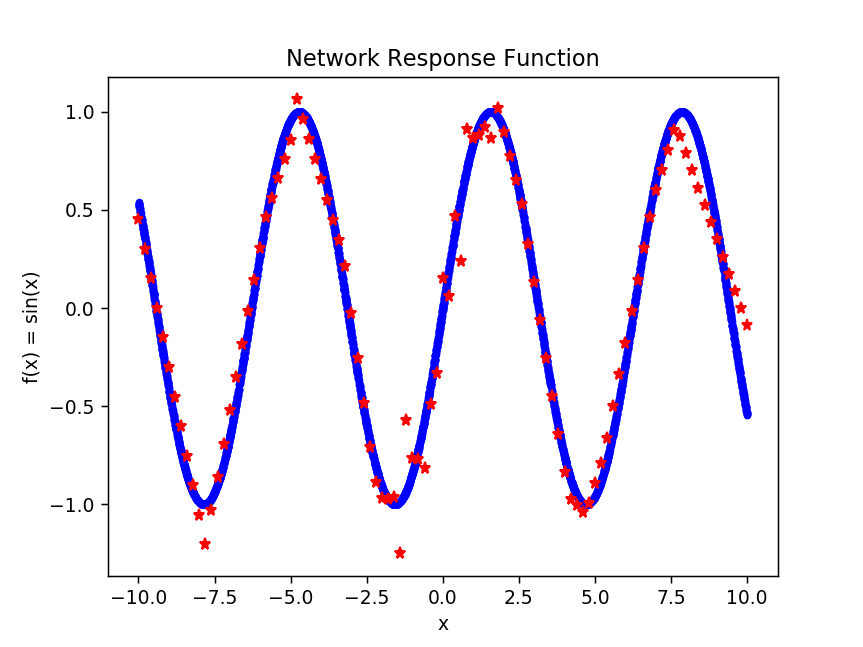

Text(0.5,1,'Network Response Function')

In [65]:
print("Note\n  The blue line is the true values of the funciton that the NN has learned to approximate.")
print("  The red line is the function learned.")
print("  Deviations between the blue and red line are errors in the modeling")

%matplotlib notebook
plt.plot(testdata, true_value, 'b.')
plt.ylabel('f(x) = sin(x)')
plt.xlabel('x')
plt.title('Test data')
plt.plot(input_value, prediction_value, 'r*')
plt.ylabel('f(x) = sin(x)')
plt.xlabel('x')
plt.title('Network Response Function')

The loss vs epoch is plotted below, where the blue is train data, and red test data


<IPython.core.display.Javascript object>


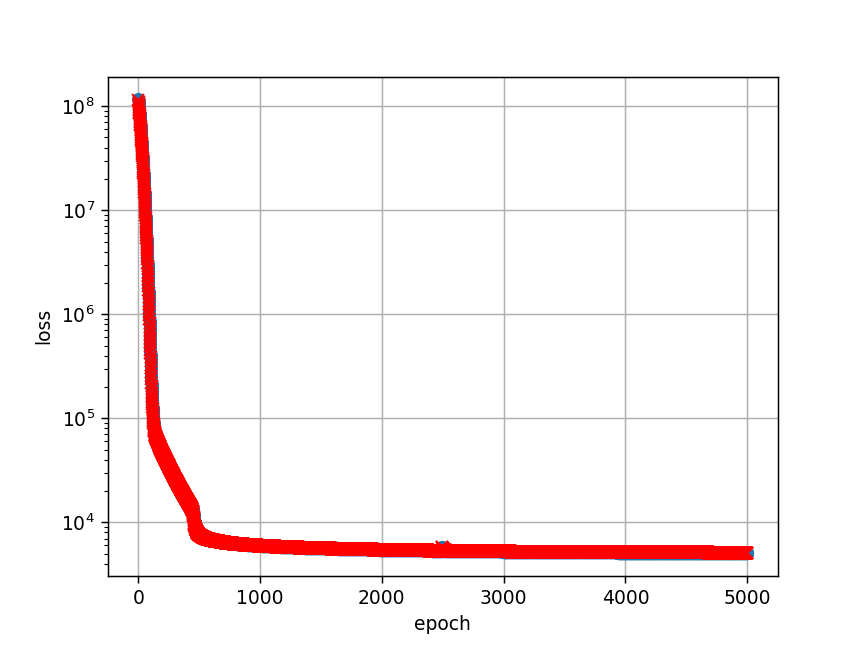

Text(0.5,0,'epoch')

In [66]:
print("The loss vs epoch is plotted below, where the blue is train data, and red test data")

%matplotlib notebook
# for log plots comment out the following
#plt.plot(epoch_set, loss_set, 'o', label='MLP Training phase')
#plt.plot(epoch_set, loss_test_value, 'rx', label='MLP Training phase')
# For log plots uncomment the following
plt.semilogy(epoch_set, loss_set, 'o', label='MLP Training phase')
plt.semilogy(epoch_set, loss_test_value, 'rx', label='MLP Training phase')
plt.grid(True)
plt.ylabel('loss')
plt.xlabel('epoch')

The difference between the loss function value for the test and train data is used
as a measure of the training.  If the train data diverges signficiantly from the test
data loss function value then the network is overtrained


<IPython.core.display.Javascript object>


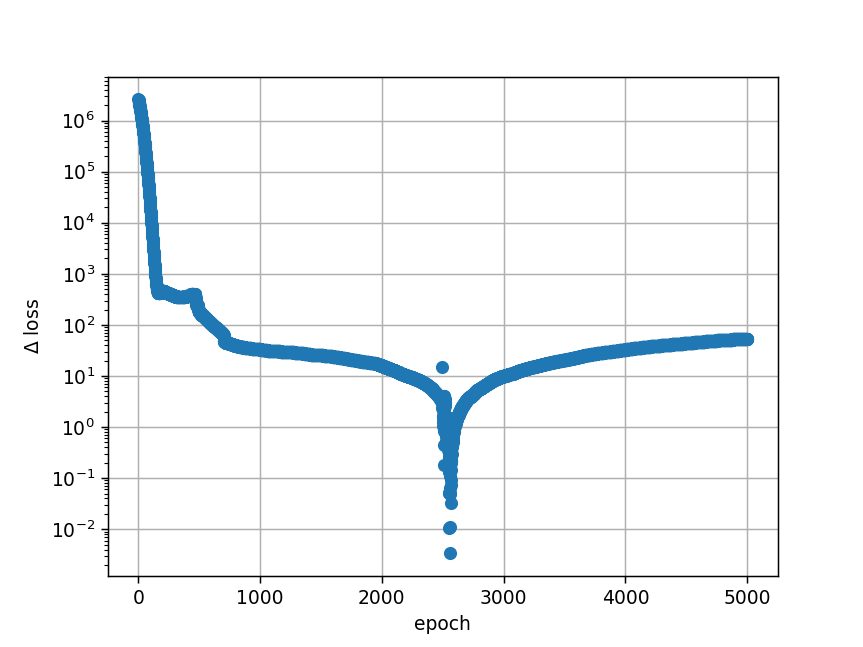

Text(0.5,0,'epoch')

In [67]:
print("The difference between the loss function value for the test and train data is used")
print("as a measure of the training.  If the train data diverges signficiantly from the test")
print("data loss function value then the network is overtrained")

%matplotlib notebook
delta = np.subtract(loss_test_value, loss_set)
plt.semilogy(epoch_set, np.absolute(delta), 'o', label='MLP Training phase')
plt.grid(True)
plt.ylabel('$\Delta$ loss')
plt.xlabel('epoch')